In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import itertools

In [2]:
pd.options.display.max_colwidth=800
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('datasets/SatisfactionClients/cdiscount_retraite.csv', index_col=0)
df_test = pd.read_csv('datasets/SatisfactionClients/amazon_test1.csv', index_col=0)
df.sample(3)

,pays,note,titre,commentaire,Commentaire_filtre,titre_filtre
115847,FR,5,SUPER,7 nov. 2018VérifiéSUPERSUPER BIEN CORECTEDate de l'expérience: 07 novembre 2018,"['nov', 'vérifiésupersuper', 'bien', 'corectedate', 'expérience', 'novembre']",['super']
111566,FR,4,D'une manière général,"29 nov. 2018VérifiéD'une manière généralD'une manière général, tous mes achats se sont bien passés. Une seule fois un gros colis est arrivé endommagé mais le service clients Cdiscount a tout réglé rapidement par téléphone. Rien à redireDate de l'expérience: 29 novembre 2018","['nov', 'vérifiéd', 'manière', 'générald', 'manière', 'général', 'tous', 'achats', 'bien', 'passés', 'seule', 'fois', 'gros', 'colis', 'arrivé', 'endommagé', 'service', 'clients', 'cdiscount', 'tout', 'réglé', 'rapidement', 'téléphone', 'rien', 'rediredate', 'expérience', 'novembre']","['manière', 'général']"
5944,FR,5,tres bien sa va aller vite merci,18 juin 2022Sur invitationtres bien sa va aller vite mercije vous remercie sa va aller tres vite bientotDate de l'expérience: 18 juin 2022,"['juin', 'invitationtres', 'bien', 'aller', 'vite', 'mercije', 'remercie', 'aller', 'tres', 'vite', 'bientotdate', 'expérience', 'juin']","['tres', 'bien', 'aller', 'vite', 'merci']"


In [4]:
# séparation de la variable cible et des variables explicatives
X = df['Commentaire_filtre']
y = df['note']

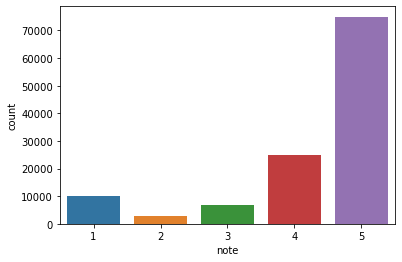

In [6]:
import seaborn as sns
sns.countplot(x='note', data=df);

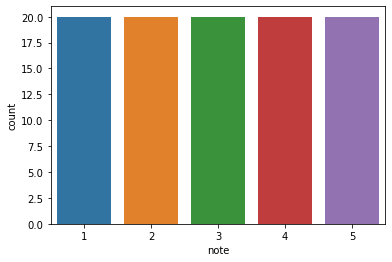

In [7]:
sns.countplot(x='note', data=df_test);

In [8]:
# séparation du jeu de données en un dataset d'entrainement et un dataset de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [9]:
# conversion des chaines de caratères en tokens numériques
# on ne prendra que les éléments répétés au moins 3 fois avec min_df=3
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=14000, ngram_range=[2, 2])
X_train = vectorizer.fit_transform(X_train).todense()
X_test = vectorizer.transform(X_test).todense()

In [10]:
print(X_train.shape)
print(X_test.shape)
print(df_test.shape)

(96000, 14000)
(24000, 14000)
(100, 4)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [12]:
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(clf.score(X_test, y_test), end='\n\n')

cr = classification_report(y_test, y_pred)
print(cr)

cm = pd.crosstab(y_test, y_pred, rownames=['données réelles'], colnames=['predictions'])
display(cm)

# vérification des résultats sur un jeu de test externe (100 commentaires amazon également répartis entre les étoiles)
df_test_token = vectorizer.transform(df_test['commentaire']).todense()
y_predict_test = clf.predict(df_test_token)

cm_test = pd.crosstab(df_test['note'], y_predict_test, rownames=['données réelles'], colnames=['predictions'])
display(cm_test)

cm_test2 = pd.crosstab(df_test['note'], y_predict_test, rownames=['données réelles'], colnames=['predictions'], normalize=0)
display(cm_test2)

for i in cm_test2.index:
    for j in cm_test2.columns :
        if (i==j and cm_test2.loc[i, j] > 0.5) :
            print("les prédictions correctes sont supérieures à 50% pour {} étoile(s) avec {} %".format(i, cm_test2.loc[i, j]*100))

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.6527083333333333

              precision    recall  f1-score   support

           1       0.65      0.66      0.65      1986
           2       0.10      0.03      0.04       551
           3       0.26      0.15      0.19      1403
           4       0.34      0.22      0.27      5034
           5       0.73      0.87      0.79     15026

    accuracy                           0.65     24000
   macro avg       0.42      0.39      0.39     24000
weighted avg       0.60      0.65      0.62     24000



predictions,1,2,3,4,5
données réelles,,,,,
1,1315,32,96,126,417
2,179,15,75,96,186
3,197,30,212,361,603
4,163,31,214,1121,3505
5,177,45,213,1589,13002


C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


predictions,1,3,4,5
données réelles,,,,
1,14,1,0,5
2,8,1,3,8
3,4,0,5,11
4,9,0,3,8
5,4,0,5,11


predictions,1,3,4,5
données réelles,,,,
1,0.70,0.05,0.00,0.25
2,0.40,0.05,0.15,0.40
3,0.20,0.00,0.25,0.55
4,0.45,0.00,0.15,0.40
5,0.20,0.00,0.25,0.55


les prédictions correctes sont supérieures à 50% pour 1 étoile(s) avec 70.0 %
les prédictions correctes sont supérieures à 50% pour 5 étoile(s) avec 55.00000000000001 %


In [14]:
from joblib import dump
dump(clf, 'datasets/SatisfactionClients/model_rf_tfidf_ngrams.jolib')

['datasets/SatisfactionClients/model_rf_tfidf_ngrams.jolib']